In [122]:
import time
import torch,torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.multiprocessing import Pool, Process, set_start_method
from torch.optim import lr_scheduler
import json

##############
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render
from ax.utils.tutorials.cnn_utils import train, evaluate

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    

try:
     set_start_method('spawn')
except RuntimeError:
    pass


In [123]:


def loadData(batch_size):
    transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    trainset = torchvision.datasets.FashionMNIST(
        root='.',
        train=True,
        transform=transform)

    testset = torchvision.datasets.FashionMNIST(
        root='.',
        train=False,
        transform=transform)

    args = {
        "batch_size": batch_size,
        "shuffle": True,
        "num_workers": 0
    }

    split_args = {}

    if torch.cuda.is_available():
        args["generator"] = torch.Generator(device='cuda')
        split_args["generator"] = torch.Generator(device='cuda')

    test_set, val_set = torch.utils.data.random_split(
        testset, [5000, 5000], **split_args)



    train_loader = torch.utils.data.DataLoader(trainset, **args)

    test_loader = torch.utils.data.DataLoader(test_set, **args)
    val_loader = torch.utils.data.DataLoader(val_set, **args)

    dataloaders = {
        "train": train_loader,
        "test": test_loader,
        "val": val_loader
    }
    return dataloaders




In [124]:
dataloaders = loadData(32)
dataset_sizes = { x: len(dataloaders[x].dataset) for x in dataloaders}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

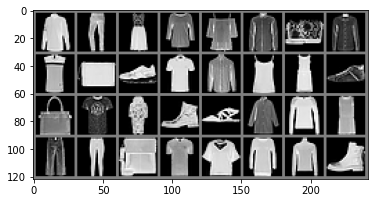

In [125]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloaders['train'])

images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels


In [126]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x




In [134]:
def train_model(model, dataloaders, parameters):
    since = time.time()

    print(parameters)
    print()
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer = optim.SGD(model.parameters(), # or any optimizer you prefer 
                        lr=parameters.get("lr", 0.001), # 0.001 is used if no lr is specified
                        momentum=parameters.get("momentum", 0.9))

    # Decay LR by a factor of 0.1 every 7 epochs
    scheduler = lr_scheduler.StepLR(optimizer,
    step_size=int(parameters.get("step_size", 30)),
    gamma=parameters.get("gamma", 0.1),
    )


    
    dataset_sizes = { x: len(dataloaders[x].dataset) for x in dataloaders}
    losses = {x:[] for x in ['train','val'] }

    num_epochs = parameters.get("num_epochs", 3)
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            #prev
            #if phase == 'train':
            #    scheduler.step()
            #current
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            losses[phase].append(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


        print()

    


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')


    return model,losses

In [130]:
def train_evaluateQ1(parameterization):

    dataloaders = loadData(parameterization.get("batchsize", 32))                
    
    # Get neural net
 
    model_ft = Net()

    # train
    trained_net,_ = train_model(model_ft, dataloaders, parameterization)

    dtype = torch.float
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    return evaluate(
            net=trained_net,
            data_loader= dataloaders["test"],
            dtype=dtype,
            device=device,
        )

    #return test_model(trained_net,dataloaders)

In [131]:
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 1.0], "log_scale": True},
        {"name": "momentum", "type": "range", "bounds": [0.2, 1.0]},
        {"name": "stepsize", "type": "range", "bounds": [0, 20]},
        {"name": "batchsize", "type": "range", "bounds": [16, 128]},
        {"name": "num_epochs", "type": "range", "bounds": [1, 2]},     
    ],
  
    evaluation_function=train_evaluateQ1,
    objective_name='accuracy',
)

print(best_parameters)
means, covariances = values
print(means)
print(covariances)




[INFO 06-07 23:29:05] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 06-07 23:29:05] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter momentum. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 06-07 23:29:05] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter stepsize. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 06-07 23:29:05] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batchsize. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dic

{'lr': 1.479591460603413e-06, 'momentum': 0.8071938991546632, 'stepsize': 6, 'batchsize': 112, 'num_epochs': 1}

Epoch 0/0
----------
train Loss: 2.3059 Acc: 0.1000
val Loss: 2.3050 Acc: 0.1038

Training complete in 0m 25s


[INFO 06-07 23:29:32] ax.service.managed_loop: Running optimization trial 2...


{'lr': 1.7180003464638314e-05, 'momentum': 0.4035969339311123, 'stepsize': 18, 'batchsize': 23, 'num_epochs': 2}

Epoch 0/1
----------
train Loss: 2.3047 Acc: 0.0246
val Loss: 2.3039 Acc: 0.0258

Epoch 1/1
----------
train Loss: 2.3042 Acc: 0.0291
val Loss: 2.3035 Acc: 0.0310

Training complete in 1m 15s


[INFO 06-07 23:30:49] ax.service.managed_loop: Running optimization trial 3...


{'lr': 6.516450891922842e-05, 'momentum': 0.7217799030244352, 'stepsize': 6, 'batchsize': 65, 'num_epochs': 1}

Epoch 0/0
----------
train Loss: 2.3052 Acc: 0.1000
val Loss: 2.3034 Acc: 0.0990

Training complete in 0m 26s


[INFO 06-07 23:31:18] ax.service.managed_loop: Running optimization trial 4...


{'lr': 0.00023277893753021367, 'momentum': 0.9944139361381532, 'stepsize': 2, 'batchsize': 100, 'num_epochs': 2}

Epoch 0/1
----------
train Loss: 1.6735 Acc: 0.4175
val Loss: 0.8738 Acc: 0.6940

Epoch 1/1
----------
train Loss: 0.6714 Acc: 0.7433
val Loss: 0.6232 Acc: 0.7672

Training complete in 0m 47s


[INFO 06-07 23:32:06] ax.service.managed_loop: Running optimization trial 5...


{'lr': 0.2020309432955378, 'momentum': 0.811322844773531, 'stepsize': 6, 'batchsize': 59, 'num_epochs': 2}

Epoch 0/1
----------
train Loss: 1.3592 Acc: 0.5042
val Loss: 1.8677 Acc: 0.3188

Epoch 1/1
----------
train Loss: 1.9655 Acc: 0.2562
val Loss: 2.3059 Acc: 0.0974

Training complete in 0m 44s


[INFO 06-07 23:32:52] ax.service.managed_loop: Running optimization trial 6...


{'lr': 1.6552902480889114e-06, 'momentum': 0.3188808545470238, 'stepsize': 20, 'batchsize': 96, 'num_epochs': 1}

Epoch 0/0
----------
train Loss: 2.3006 Acc: 0.1000
val Loss: 2.3001 Acc: 0.1034

Training complete in 0m 21s


[INFO 06-07 23:33:15] ax.service.managed_loop: Running optimization trial 7...


{'lr': 1.142313124022188e-05, 'momentum': 0.6084258012473583, 'stepsize': 12, 'batchsize': 110, 'num_epochs': 1}

Epoch 0/0
----------
train Loss: 2.3062 Acc: 0.1092
val Loss: 2.3062 Acc: 0.1136

Training complete in 0m 22s


[INFO 06-07 23:33:38] ax.service.managed_loop: Running optimization trial 8...


{'lr': 0.5058350188679535, 'momentum': 0.3071160487830639, 'stepsize': 12, 'batchsize': 33, 'num_epochs': 1}

Epoch 0/0
----------
train Loss: 2.2094 Acc: 0.1665
val Loss: 2.3049 Acc: 0.0974

Training complete in 0m 28s


[INFO 06-07 23:34:09] ax.service.managed_loop: Running optimization trial 9...


{'lr': 1.7101808497151638e-05, 'momentum': 0.6232541985809803, 'stepsize': 5, 'batchsize': 37, 'num_epochs': 1}

Epoch 0/0
----------
train Loss: 2.3057 Acc: 0.1000
val Loss: 2.3056 Acc: 0.1004

Training complete in 0m 29s


[INFO 06-07 23:34:40] ax.service.managed_loop: Running optimization trial 10...


{'lr': 0.6474317082895489, 'momentum': 0.6644708238542081, 'stepsize': 6, 'batchsize': 107, 'num_epochs': 2}

Epoch 0/1
----------
train Loss: 2.3060 Acc: 0.1037
val Loss: 2.3068 Acc: 0.0970

Epoch 1/1
----------
train Loss: 2.3065 Acc: 0.1002
val Loss: 2.3057 Acc: 0.0974

Training complete in 0m 48s


[INFO 06-07 23:35:30] ax.service.managed_loop: Running optimization trial 11...


{'lr': 0.00012190202612563083, 'momentum': 1.0, 'stepsize': 1, 'batchsize': 106, 'num_epochs': 2}

Epoch 0/1
----------
train Loss: 2.0128 Acc: 0.3121
val Loss: 1.1145 Acc: 0.6084

Epoch 1/1
----------
train Loss: 0.9480 Acc: 0.6571
val Loss: 0.7808 Acc: 0.7218

Training complete in 0m 48s


[INFO 06-07 23:36:24] ax.service.managed_loop: Running optimization trial 12...


{'lr': 0.00021583873217283892, 'momentum': 1.0, 'stepsize': 3, 'batchsize': 96, 'num_epochs': 2}

Epoch 0/1
----------
train Loss: 1.8108 Acc: 0.3646
val Loss: 1.0664 Acc: 0.6068

Epoch 1/1
----------
train Loss: 0.8128 Acc: 0.6993
val Loss: 0.7131 Acc: 0.7266

Training complete in 0m 49s


[INFO 06-07 23:37:20] ax.service.managed_loop: Running optimization trial 13...


{'lr': 0.0005629465080694524, 'momentum': 1.0, 'stepsize': 1, 'batchsize': 101, 'num_epochs': 2}

Epoch 0/1
----------
train Loss: 1.4730 Acc: 0.4517
val Loss: 0.7737 Acc: 0.7156

Epoch 1/1
----------
train Loss: 0.7196 Acc: 0.7353
val Loss: 0.7593 Acc: 0.7286

Training complete in 0m 50s


[INFO 06-07 23:38:19] ax.service.managed_loop: Running optimization trial 14...


{'lr': 0.000277458944043827, 'momentum': 0.9614417807962687, 'stepsize': 2, 'batchsize': 102, 'num_epochs': 2}

Epoch 0/1
----------
train Loss: 2.2854 Acc: 0.2112
val Loss: 2.2446 Acc: 0.3626

Epoch 1/1
----------
train Loss: 1.6316 Acc: 0.4819
val Loss: 0.9188 Acc: 0.6436

Training complete in 0m 48s


[INFO 06-07 23:39:16] ax.service.managed_loop: Running optimization trial 15...


{'lr': 0.00014549341151976183, 'momentum': 1.0, 'stepsize': 1, 'batchsize': 87, 'num_epochs': 2}

Epoch 0/1
----------
train Loss: 1.9408 Acc: 0.3337
val Loss: 1.1841 Acc: 0.6374

Epoch 1/1
----------
train Loss: 0.9392 Acc: 0.6633
val Loss: 0.7659 Acc: 0.7170

Training complete in 0m 52s


[INFO 06-07 23:40:16] ax.service.managed_loop: Running optimization trial 16...


{'lr': 0.00024343691132984582, 'momentum': 1.0, 'stepsize': 2, 'batchsize': 97, 'num_epochs': 2}

Epoch 0/1
----------
train Loss: 1.7971 Acc: 0.3987
val Loss: 1.0219 Acc: 0.5928

Epoch 1/1
----------
train Loss: 0.8286 Acc: 0.6890
val Loss: 0.8045 Acc: 0.6976

Training complete in 0m 52s


[INFO 06-07 23:41:16] ax.service.managed_loop: Running optimization trial 17...


{'lr': 0.00023003224836824673, 'momentum': 1.0, 'stepsize': 1, 'batchsize': 97, 'num_epochs': 2}

Epoch 0/1
----------
train Loss: 1.9198 Acc: 0.3230
val Loss: 1.1676 Acc: 0.5712

Epoch 1/1
----------
train Loss: 0.7970 Acc: 0.7021
val Loss: 0.7732 Acc: 0.7240

Training complete in 0m 45s


[INFO 06-07 23:42:08] ax.service.managed_loop: Running optimization trial 18...


{'lr': 0.00020913721940148464, 'momentum': 1.0, 'stepsize': 2, 'batchsize': 98, 'num_epochs': 2}

Epoch 0/1
----------
train Loss: 1.7300 Acc: 0.4009
val Loss: 0.9097 Acc: 0.6634

Epoch 1/1
----------
train Loss: 0.7921 Acc: 0.6964
val Loss: 0.7149 Acc: 0.7268

Training complete in 0m 49s


[INFO 06-07 23:43:05] ax.service.managed_loop: Running optimization trial 19...


{'lr': 0.00022250416121013302, 'momentum': 1.0, 'stepsize': 2, 'batchsize': 98, 'num_epochs': 2}

Epoch 0/1
----------
train Loss: 1.9406 Acc: 0.2709
val Loss: 1.1297 Acc: 0.6084

Epoch 1/1
----------
train Loss: 0.8163 Acc: 0.6998
val Loss: 0.7020 Acc: 0.7492

Training complete in 0m 45s


[INFO 06-07 23:43:56] ax.service.managed_loop: Running optimization trial 20...


{'lr': 0.00022090020710391857, 'momentum': 1.0, 'stepsize': 2, 'batchsize': 98, 'num_epochs': 2}

Epoch 0/1
----------
train Loss: 1.7599 Acc: 0.3466
val Loss: 1.0099 Acc: 0.5826

Epoch 1/1
----------
train Loss: 0.7731 Acc: 0.7049
val Loss: 0.7441 Acc: 0.7274

Training complete in 0m 50s
{'lr': 0.00022250416121013302, 'momentum': 1.0, 'stepsize': 2, 'batchsize': 98, 'num_epochs': 2}
{'accuracy': 0.732984245831027}
{'accuracy': {'accuracy': 7.738923799252455e-05}}


In [132]:
best_objectives = np.array([[trial.objective_mean*100 for trial in experiment.trials.values()]])

best_objective_plot = optimization_trace_single_method(
    y=np.maximum.accumulate(best_objectives, axis=1),
    title="Model performance vs. # of iterations",
    ylabel="Classification Accuracy, %",
)
render(best_objective_plot)

render(plot_contour(model=model, param_x='batchsize', param_y='lr', metric_name='accuracy'))

## train for the best arm

In [135]:
data = experiment.fetch_data()
df = data.df
best_arm_name = df.arm_name[df['mean'] == df['mean'].max()].values[0]
best_arm = experiment.arms_by_name[best_arm_name]
best_arm

with open('Q1_best_arm', 'w') as fout:
        json.dump(best_arm.parameters, fout)

dataloaders = loadData(best_arm.parameters.get("batchsize", 32))                

# Get neural net
model_ft = Net()

# train
trained_net,losses = train_model(model_ft, dataloaders, best_arm.parameters)

with open('Q1_Losess', 'w') as fout:
    json.dump(losses, fout)


PATH = "Q1_state_dict_model.pt"
torch.save(trained_net.state_dict(), PATH)


dtype = torch.float
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# acc =test_model(trained_net, dataloaders)
acc = evaluate(
            net=trained_net,
            data_loader= dataloaders["test"],
            dtype=dtype,
            device=device,
        )

{'lr': 0.00023277893753021367, 'momentum': 0.9944139361381532, 'stepsize': 2, 'batchsize': 100, 'num_epochs': 2}

Epoch 0/1
----------
train Loss: 1.8988 Acc: 0.3405
val Loss: 1.0333 Acc: 0.6574

Epoch 1/1
----------
train Loss: 0.7191 Acc: 0.7267
val Loss: 0.6303 Acc: 0.7638

Training complete in 0m 50s


In [136]:
acc

0.768

In [137]:
dtype = torch.float
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


acc = evaluate(
            net=trained_net,
            data_loader= dataloaders["test"],
            dtype=dtype,
            device=device,
        )
acc

0.768

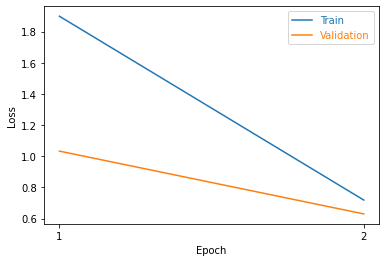

In [138]:
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt

host = host_subplot(111)


host.set_xlabel("Epoch")
host.set_ylabel("Loss")



plt.xticks(range(1,len(losses['train']) + 1 ) )

X = [i + 1 for i in range(len(losses['train']))]

p1, = host.plot(X, losses['train'], label="Train")
p2, = host.plot(X,losses['val'], label="Validation")



leg = plt.legend()

leg.texts[0].set_color(p1.get_color())
leg.texts[1].set_color(p2.get_color())

plt.show()

## Q2

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.eval()


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class MyNet(nn.Module):
    def __init__(self, pre_trained_model, out_features):
        super().__init__()
        self.pre_trained_model = pre_trained_model

        in_features = pre_trained_model.fc.out_features

        self.output_layers = nn.Sequential(
            nn.Linear(in_features, 100),
            nn.ReLU(),
            nn.Linear(100, out_features))

        def forward(self, x):
            x = x.repeat(3,1)
            x = self.pre_trained_model(x)
            x = self.output_layers(x)
        

In [ ]:
myNet = MyNet(model,10)

In [ ]:
train_model(myNet)

TypeError: train_model() missing 4 required positional arguments: 'dataloaders', 'criterion', 'optimizer', and 'scheduler'

# Temp test model

In [ ]:
def test_model(model, dataloaders):

    criterion = nn.CrossEntropyLoss()
    # Each epoch has a training and validation phase

    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)


    loss = running_loss / dataset_sizes['test']
    acc = running_corrects.double() / dataset_sizes['test']

    print(f'test Loss: {loss:.4f} Acc: {acc:.4f}')
    return acc





<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=07815b58-9f1b-4f2e-9ca1-e734f8d7281b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>